In [1]:
# Standard imports
import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from math import sqrt

# XGboost model
import xgboost as xgb

# Model selection tools
from sklearn.model_selection import GridSearchCV

# Error metrics
from sklearn.metrics import mean_squared_error

In [2]:
def parser(x):
    return datetime.strptime(x, '%d-%b-%Y')

def get_data(path, date):
    data = pd.read_csv(path , header=0, parse_dates=[date], index_col=date, squeeze=True, date_parser=parser)
    return data

In [3]:
# setup regressor
xgb_model = xgb.XGBRegressor()

# perform a grid search
tweaked_model = GridSearchCV(
    xgb_model,
    {
        'max_depth': range(1, 11, 1),
        'n_estimators': range(20, 100, 1),
        'learning_rate': [0.1, 0.2, 0.3]
    },
    cv=10,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 3093 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 4843 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 6629 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9383 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 12948 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 14448 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 16346 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 21267 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 23367 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 23985 out of 24000 | elapsed:  6.0min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.0min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selecti

Best: -35094.694217 using {'max_depth': 2, 'n_estimators': 85, 'learning_rate': 0.2}


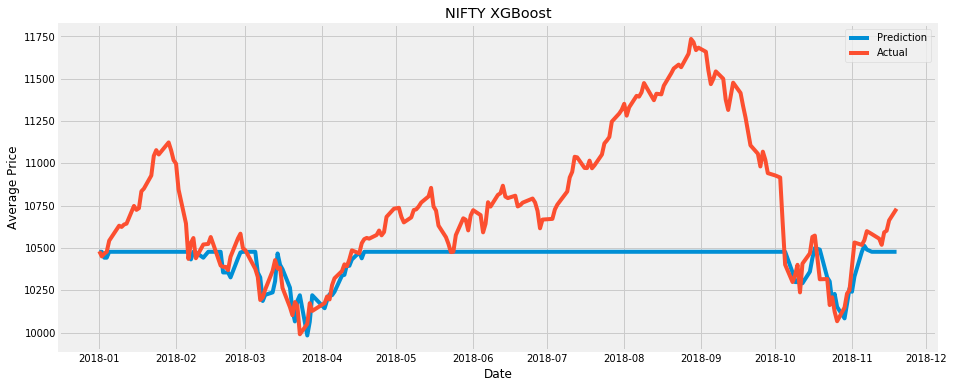

RMSE: 475.1513729174077
MAPE: 3.01822334840831


In [4]:
look_back = 5
title = 'NIFTY'
x = get_data('../ml-project-data/NIFTY_train.csv', 0)
y = x.loc[: , "High":"Low"].mean(axis=1)
        
x_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    x_lag['t-'+str(i)] = y.shift(i)

x = x_lag

x = x.iloc[look_back:]
y = y.iloc[look_back:]

act_data = get_data('../ml-project-data/NIFTY_test.csv', 0)
idx = act_data.index
act = act_data.loc[: , "High":"Low"].mean(axis=1)
act_y = act
act = pd.concat([y[-5:], act])

act_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    act_lag['t-'+str(i)] = act.shift(i)

act = act_lag[look_back:]

tweaked_model.fit(x, y)

# summarize results
print("Best: %f using %s" % (tweaked_model.best_score_, tweaked_model.best_params_))

pred = tweaked_model.predict(act)
preds = pd.DataFrame(np.array(pred),index = act.index,columns=['Prediction'])
plt.figure(figsize=(14,6))
plt.plot(idx, preds, label="Prediction")
plt.plot(idx, act_y, label="Actual")
plt.ylabel("Average Price")
plt.xlabel('Date')
plt.title(title + " XGBoost")
plt.legend(loc="best")
plt.show()

rms = sqrt(mean_squared_error(act_y, pred))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((act_y - pred) / act_y)) * 100
print('MAPE: ' + str(mape))

In [5]:
def company_wo_nifty(train_path, test_path, title):
    tcs_x = get_data(train_path, 2)['Average Price']
    tcs_y = tcs_x

    tcs_x_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_x_lag['t-'+str(i)] = tcs_y.shift(i)

    tcs_x = tcs_x_lag

    tcs_x = tcs_x.iloc[look_back:]
    tcs_y = tcs_y.iloc[look_back:]
    
    tcs_act = get_data(test_path, 2)['Average Price']
    idx = tcs_act.index
    tcs_act_y = tcs_act
    tcs_act = pd.concat([tcs_y[-5:], tcs_act])

    tcs_act_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_act_lag['t-'+str(i)] = tcs_act.shift(i)

    tcs_act = tcs_act_lag[look_back:]
    
    tweaked_model.fit(tcs_x, tcs_y)

    # summarize results
    print("Best: %f using %s" % (tweaked_model.best_score_, tweaked_model.best_params_))
    
    tcs_pred = tweaked_model.predict(tcs_act)
    
    tcs_preds = pd.DataFrame(np.array(tcs_pred),index = act.index,columns=['Prediction'])
    plt.figure(figsize=(14,6))
    plt.plot(idx, tcs_preds, label="Prediction")
    plt.plot(idx, tcs_act_y, label="Actual")
    plt.ylabel("Average Price")
    plt.xlabel('Date')
    plt.title(title + " XGBoost wo NIFTY")
    plt.legend(loc="best")
    plt.show()
    
    rms = sqrt(mean_squared_error(tcs_act_y, tcs_pred))
    print('RMSE: ' + str(rms))

    mape = np.mean(np.abs((tcs_act_y - tcs_pred) / tcs_act_y)) * 100
    print('MAPE: ' + str(mape))

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 3073 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 4123 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 5473 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 7123 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 10009 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 13264 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 15814 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 21014 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 23424 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  5.9min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change

Best: -3471.282160 using {'max_depth': 9, 'n_estimators': 26, 'learning_rate': 0.2}


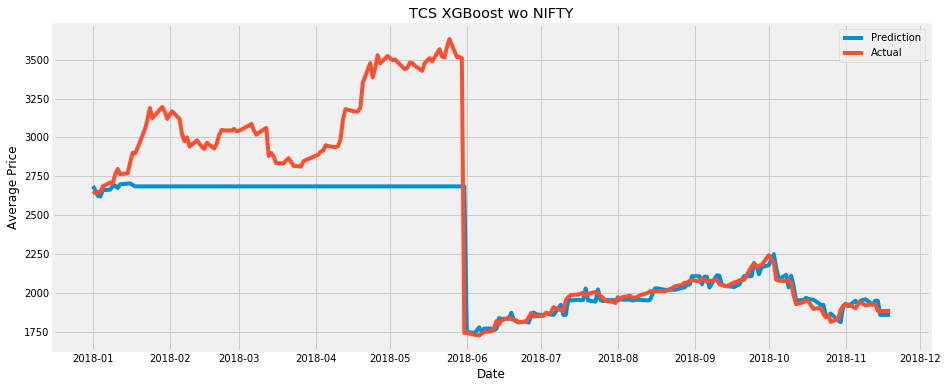

RMSE: 347.15174185620157
MAPE: 6.990555072479861


In [6]:
company_wo_nifty('../ml-project-data/TCS_train.csv', '../ml-project-data/TCS_test.csv', 'TCS')

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 3073 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 4123 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 5473 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7123 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 10033 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 13264 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 15814 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 20304 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 23454 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.2min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change

Best: -10950.552979 using {'max_depth': 2, 'n_estimators': 53, 'learning_rate': 0.1}


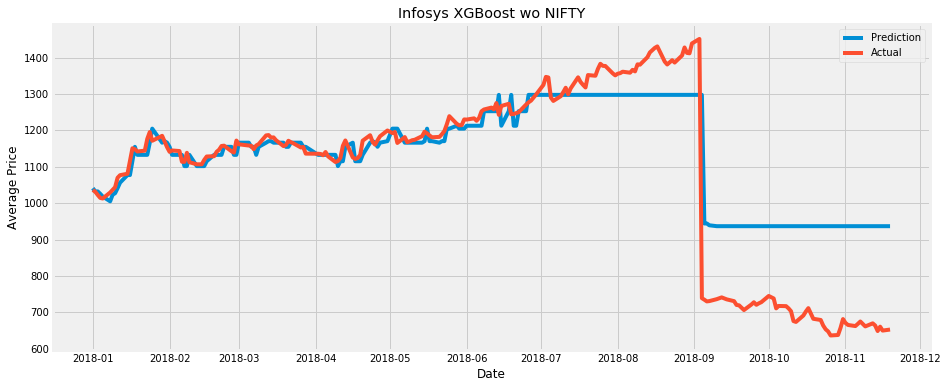

RMSE: 128.03554614123877
MAPE: 10.033083227101745


In [7]:
company_wo_nifty('../ml-project-data/INFY_train.csv', '../ml-project-data/INFY_test.csv', 'Infosys')

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 3199 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 4249 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 5599 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7249 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 10276 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 13387 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 15937 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 21178 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 23500 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.1min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change

Best: -4343.810404 using {'max_depth': 1, 'n_estimators': 98, 'learning_rate': 0.1}


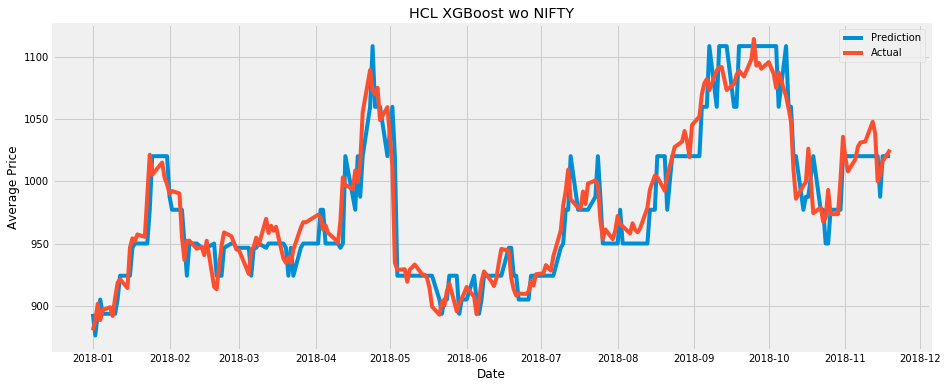

RMSE: 18.897340318520328
MAPE: 1.4897004475757951


In [8]:
company_wo_nifty('../ml-project-data/HCL_train.csv', '../ml-project-data/HCL_test.csv', 'HCL')

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1696 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 3316 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 4919 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 5819 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6919 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 8749 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 12262 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 14812 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 19167 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 22707 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.3min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change 

Best: -9438.067658 using {'max_depth': 1, 'n_estimators': 52, 'learning_rate': 0.2}


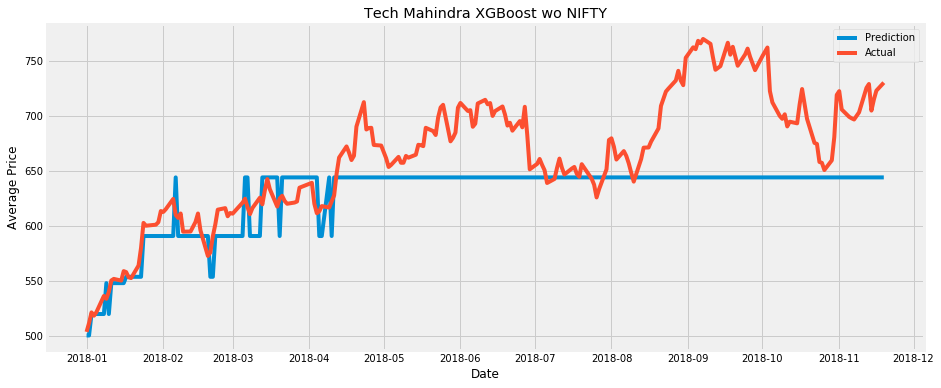

RMSE: 51.476791532907335
MAPE: 5.630836708111272


In [9]:
company_wo_nifty('../ml-project-data/TECHM_train.csv', '../ml-project-data/TECHM_test.csv', 'Tech Mahindra')

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1892 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2892 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 4292 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 5392 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 10409 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 13366 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 15066 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 19473 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 22356 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.2min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change

Best: -296.486668 using {'max_depth': 2, 'n_estimators': 88, 'learning_rate': 0.1}


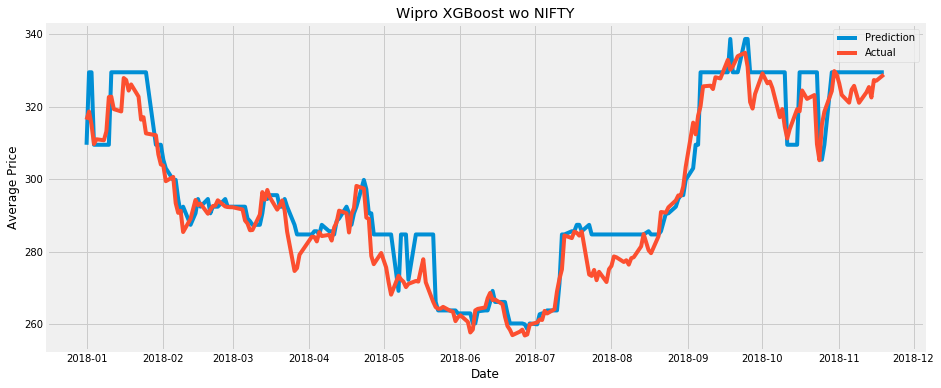

RMSE: 6.434699267260752
MAPE: 1.62607597466029


In [10]:
company_wo_nifty('../ml-project-data/WIPRO_train.csv', '../ml-project-data/WIPRO_test.csv', 'Wipro')

In [11]:
def company_w_nifty(train_path, test_path, title):
    tcs_x = get_data(train_path, 2)['Average Price']
    tcs_y = tcs_x

    tcs_x_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_x_lag['t-'+str(i)] = tcs_y.shift(i)

    tcs_x = tcs_x_lag

    tcs_x = tcs_x.iloc[look_back:]
    tcs_y = tcs_y.iloc[look_back:]

    tcs_act = get_data(test_path, 2)['Average Price']
    idx = tcs_act.index
    tcs_act_y = tcs_act
    tcs_act = pd.concat([tcs_y[-5:], tcs_act])

    tcs_act_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_act_lag['t-'+str(i)] = tcs_act.shift(i)

    tcs_act = tcs_act_lag[look_back:]

    tcs_x['nifty'] = y
    tcs_act['nifty'] = preds

    tweaked_model.fit(tcs_x, tcs_y)

    # summarize results
    print("Best: %f using %s" % (tweaked_model.best_score_, tweaked_model.best_params_))

    tcs_pred = tweaked_model.predict(tcs_act)
                       
    tcs_preds = pd.DataFrame(np.array(tcs_pred),index = act.index,columns=['Prediction'])
    plt.figure(figsize=(14,6))
    plt.plot(idx, tcs_preds, label="Prediction")
    plt.plot(idx, tcs_act_y, label="Actual")
    plt.ylabel("Average Price")
    plt.xlabel('Date')
    plt.title(title + " XGBoost w NIFTY")
    plt.legend(loc="best")
    plt.show()
    
    rms = sqrt(mean_squared_error(tcs_act_y, tcs_pred))
    print('RMSE: ' + str(rms))

    mape = np.mean(np.abs((tcs_act_y - tcs_pred) / tcs_act_y)) * 100
    print('MAPE: ' + str(mape))

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1054 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 3054 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 4538 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 6338 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 8562 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 12587 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 14234 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 15934 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 21124 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 23224 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.1min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change

Best: -3471.282160 using {'max_depth': 9, 'n_estimators': 26, 'learning_rate': 0.2}


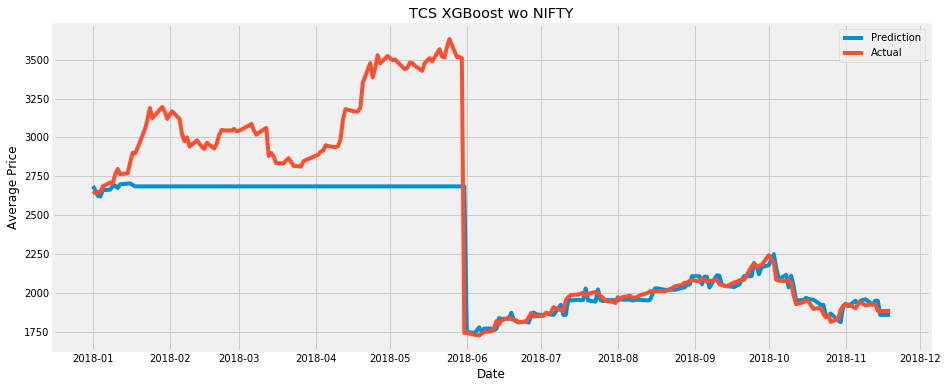

RMSE: 347.15174185620157
MAPE: 6.990555072479861


In [12]:
company_wo_nifty('../ml-project-data/TCS_train.csv', '../ml-project-data/TCS_test.csv', 'TCS')

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1948 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 2948 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 4348 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 6148 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7388 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 10516 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 13844 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 15790 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 20985 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 23085 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 23985 out of 24000 | elapsed:  6.1min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.2min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selecti

Best: -10950.552979 using {'max_depth': 2, 'n_estimators': 53, 'learning_rate': 0.1}


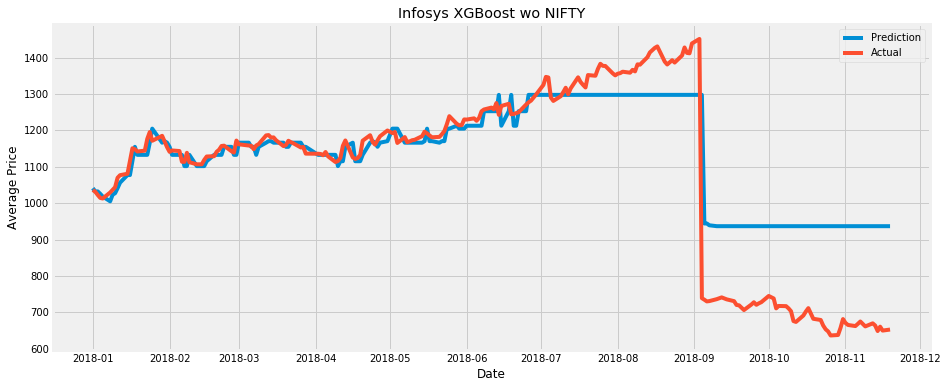

RMSE: 128.03554614123877
MAPE: 10.033083227101745


In [13]:
company_wo_nifty('../ml-project-data/INFY_train.csv', '../ml-project-data/INFY_test.csv', 'Infosys')

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 3199 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 4249 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 5599 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7249 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 10222 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 13348 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 15898 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 20341 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 23359 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 23985 out of 24000 | elapsed:  6.4min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.4min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selecti

Best: -4343.810404 using {'max_depth': 1, 'n_estimators': 98, 'learning_rate': 0.1}


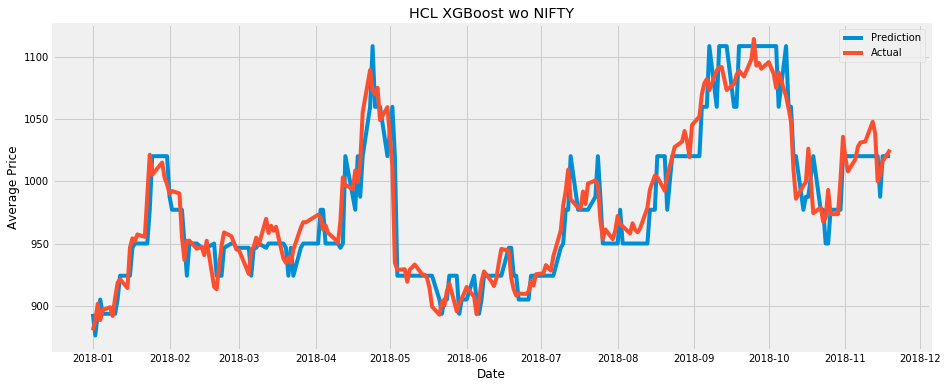

RMSE: 18.897340318520328
MAPE: 1.4897004475757951


In [14]:
company_wo_nifty('../ml-project-data/HCL_train.csv', '../ml-project-data/HCL_test.csv', 'HCL')

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 3910 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 4987 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 6337 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 7929 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11958 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 13959 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 15659 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 20159 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 22933 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 23985 out of 24000 | elapsed:  6.5min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.5min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selecti

Best: -9438.067658 using {'max_depth': 1, 'n_estimators': 52, 'learning_rate': 0.2}


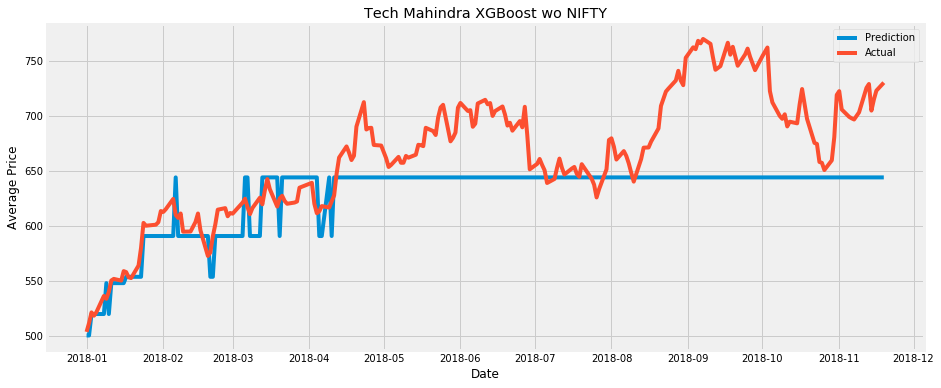

RMSE: 51.476791532907335
MAPE: 5.630836708111272


In [15]:
company_wo_nifty('../ml-project-data/TECHM_train.csv', '../ml-project-data/TECHM_test.csv', 'Tech Mahindra')

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2374 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 3526 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 5926 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7576 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 10882 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 13651 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 15801 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 20944 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 23044 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  6.5min finished
C:\Users\Colossus\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change

Best: -296.486668 using {'max_depth': 2, 'n_estimators': 88, 'learning_rate': 0.1}


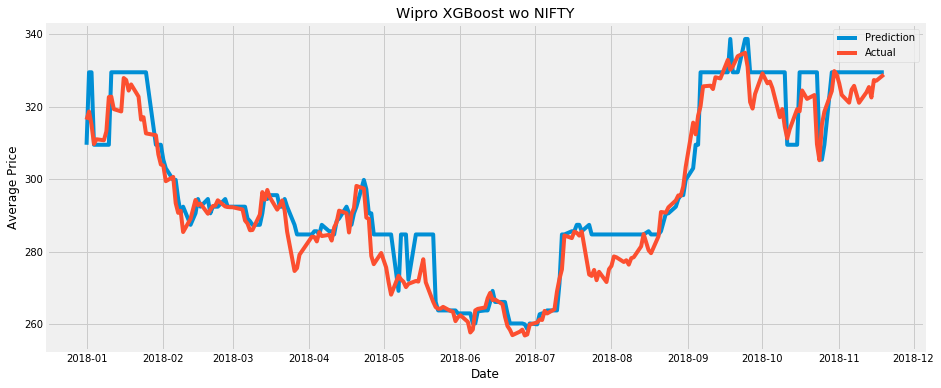

RMSE: 6.434699267260752
MAPE: 1.62607597466029


In [16]:
company_wo_nifty('../ml-project-data/WIPRO_train.csv', '../ml-project-data/WIPRO_test.csv', 'Wipro')